# Simple RNN을 이용한 스팸 분류
- 

In [1]:
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [3]:
import pandas as pd
df=pd.read_csv(url,encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


데이터 전처리

In [4]:
#selection
df=df[['v1','v2']]
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
#null값 확인
df.isna().sum()

v1    0
v2    0
dtype: int64

In [7]:
#중복 데이터 확인
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [8]:
df.drop_duplicates(subset=['v2'],inplace=True)
df.shape

(5169, 2)

In [9]:
#['ham','spam']=>[0,1]
df.v1 = df.v1.replace(['ham','spam'],[0,1])
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [11]:
#ham/spam 분포
df.v1.value_counts()
#비율이 안 좋다

0    4516
1     653
Name: v1, dtype: int64

In [12]:
#전처리 완료된 파일을 만들어 둔다.
df.to_csv('스팸_전처리완료.csv',index=False)

In [13]:
x=df.v2.values
y=df.v1.values

x.shape,y.shape

((5169,), (5169,))

텍스트 전처리

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
#encoding, 구둣점 제거, 소문자로 변환
import re

def preprocessing(s):
    s=s.encode('utf8').decode('ascii','ignore')
    s=re.sub('[^a-z0-9 ]','',s.lower())
    return s


In [16]:
X_data=[preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [17]:
t=Tokenizer()
t.fit_on_texts(X_data)

vocab_size=len(t.word_index)+1
vocab_size

9479

In [18]:
#시퀀스 생성
sequences=t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [19]:
max_len=max(len(seq) for seq in sequences)
max_len

171

In [24]:
#전체 데이터를 max_len 길이에 맞도록 0 padding
data=pad_sequences(sequences, maxlen=max_len)

- train/test data set 분리

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    data,y,stratify=y,test_size=0.2,random_state=2022
)
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

- 모델 정의/설정/학습

In [27]:
import tensorflow as tf
import numpy as np
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [32]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [33]:
model=Sequential([
                  Embedding(vocab_size,32,input_length=max_len),
                  SimpleRNN(32),
                  Dense(1,activation='sigmoid')
])
model.summary()
#아까와 달리 지금은 y값이 별도로 있기 때문에 max_len 에서 1 안 빼도 됨


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 171, 32)           303328    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile('adam','binary_crossentropy',['accuracy'])

In [37]:
model_path='best-spam-rnn.h5'
mc=ModelCheckpoint(model_path,verbose=1,save_best_only=True)
es=EarlyStopping(patience=10)

In [ ]:
hist=model.fit(
    X_train,y_train,validation_split=0.2,
    epochs=100,batch_size=64,callbacks=[mc,es]
)

In [39]:
best_model=load_model(model_path)
best_model.evaluate(X_test,y_test)

33/33 [==============================] - 1s 9ms/step - loss: 0.0786 - accuracy: 0.9778


[0.07856273651123047, 0.9777562618255615]

학습과정 시각화

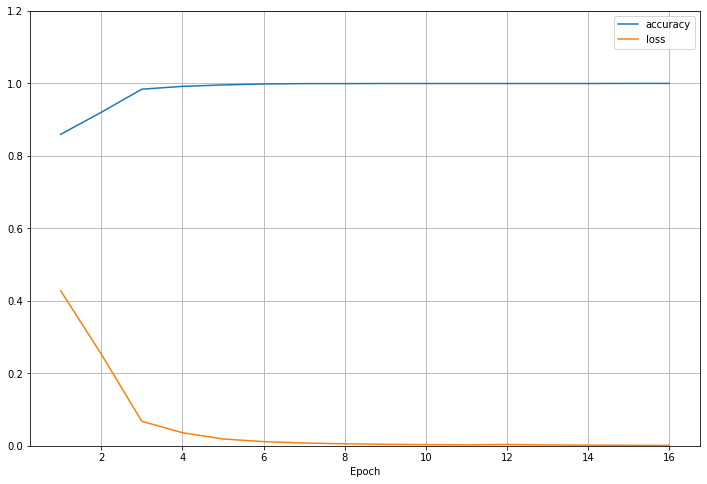

In [40]:
y_acc=hist.history['accuracy']
y_loss=hist.history['loss']
xs=np.arange(1,len(y_acc)+1)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs,y_acc,label='accuracy')
plt.plot(xs,y_loss,label='loss')
plt.legend(),plt.grid()
plt.ylim(0,1.2),plt.xlabel('Epoch')
plt.show()